In [11]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings('ignore')
DB_HOST = 'localhost'
DB_NAME = 'tw'
DB_USER = 'mini'
DB_PASS = 'buddyrich134'
def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn

conn = get_db_connection()
cursor = conn.cursor()

twse_query = "SELECT da, op, hi, lo, cl from public.price where code = 'TWSE Index' order by da asc;"
cursor.execute(twse_query)
conn.commit()
twse_res = cursor.fetchall()
twse = pd.DataFrame(twse_res)
twse.columns = ['da', 'open', 'high', 'low', 'close']
twse.set_index('da', inplace=True)

two_query = "SELECT da, op, hi, lo, cl from public.price where code = 'TWOTCI Index' order by da asc;"
cursor.execute(two_query)
conn.commit()
twotci_res = cursor.fetchall()
twotci = pd.DataFrame(twotci_res)
twotci.columns = ['da', 'open', 'high', 'low', 'close']
twotci.set_index('da', inplace=True)

twotci['ticker'] = "TWOTCI"
twse['ticker'] = "TWSE"
df = pd.concat([twse, twotci], axis=0)

filtered_df = df.copy()
filtered_df['AvgPrice'] = (filtered_df['high'] + filtered_df['low']) / 2
filtered_df['Return'] = filtered_df.groupby('ticker')['AvgPrice'].pct_change()
filtered_df['beta'] = filtered_df.groupby('ticker')['close'].pct_change().shift(-1)

def rolling_std(group):
    group['return_stddev'] = group['Return'].rolling(window=5).std() * 100
    return group

filtered_df = filtered_df.groupby('ticker').apply(rolling_std).reset_index(level='ticker', drop=True)

def calculate_moving_averages(df):
    df['MA20'] = df['close'].rolling(window=20).mean()
    df['MA60'] = df['close'].rolling(window=60).mean()
    return df

filtered_df = filtered_df.groupby('ticker').apply(calculate_moving_averages).reset_index(level='ticker', drop=True)
start_date = '2015-01-01'
twse = filtered_df[(filtered_df['ticker'] == 'TWSE') & (filtered_df.index >= start_date)][['close', 'AvgPrice', "Return", "beta", "return_stddev", "MA20", "MA60"]]
twotci = filtered_df[(filtered_df['ticker'] == 'TWOTCI') & (filtered_df.index >= start_date)][['close', 'AvgPrice', "Return", "beta", "return_stddev", "MA20", "MA60"]]
twotci.reset_index(inplace=True)
twotci['da'] = pd.to_datetime(twotci['da'])
twse.reset_index(inplace=True)
twse['da'] = pd.to_datetime(twse['da'])

### Backtest

In [12]:
def calculate_twotci_metrics(row):
    date = row['da']
    twotci_today = twotci[twotci['da'] == date]
    twotci_next = twotci[twotci['da'] > date].sort_values(by='da').head(1)

    if not twotci_today.empty and not twotci_next.empty:
        twotci_beta = twotci_next['close'].values[0] / twotci_today['close'].values[0] - 1
    else:
        twotci_beta = np.nan
    
    twotci_return_stddev = twotci[(twotci['da'] >= (pd.to_datetime(date) - pd.Timedelta(days=5))) & (twotci['da'] <= date)]['Return'].std() * 100
    twotci_ma20 = twotci[twotci['da'] <= date].sort_values(by='da', ascending=False).head(20)['close'].mean()
    twotci_ma60 = twotci[twotci['da'] <= date].sort_values(by='da', ascending=False).head(60)['close'].mean()
    twotci_cl = twotci_today['close'].values[0] if not twotci_today.empty else np.nan
    
    return pd.Series([twotci_beta, twotci_return_stddev, twotci_ma20, twotci_ma60, twotci_cl])

final_df = twse.copy()
final_df[['TWOTCI_BETA', 'TWOTCI_RETURN_STDDEV', 'TWOTCI_MA20', 'TWOTCI_MA60', 'TWOTCI_CL']] = final_df.apply(calculate_twotci_metrics, axis=1)
final_df.set_index('da', inplace=True, drop=False)

In [58]:
# 4 dimensions, used for factor timing
'''四種分別是
上市漲 上櫃漲
上市漲 上櫃跌
上市跌 上櫃漲
上市跌 上櫃跌
'''

real_exposure = []
real_exposure_type = []
final_df['TWOTCI_RETURN_STDDEV_PREV'] = final_df['TWOTCI_RETURN_STDDEV'].shift(1)
for index, row in final_df.iterrows():
    if row['TWOTCI_RETURN_STDDEV'] <= 3 and row['TWOTCI_CL'] > row['TWOTCI_MA20']:
        real_exposure_type.append(1)
        real_exposure.append(1)
    elif row['return_stddev'] >= 3.5:
        real_exposure_type.append(2)
        real_exposure.append(1)
    elif row['TWOTCI_RETURN_STDDEV'] <= 1:
        real_exposure_type.append(2.5)
        real_exposure.append(1)
    elif (row['TWOTCI_RETURN_STDDEV']-row['TWOTCI_RETURN_STDDEV_PREV']) > 0.5 and row['TWOTCI_CL'] > row['TWOTCI_MA60'] and row['TWOTCI_CL'] < row['TWOTCI_MA20']:
        real_exposure_type.append(3)
        real_exposure.append(1)
    else:
        real_exposure_type.append(4)
        real_exposure.append(0)

final_df['signal_ed'] = real_exposure
final_df['signal_comment'] = real_exposure_type

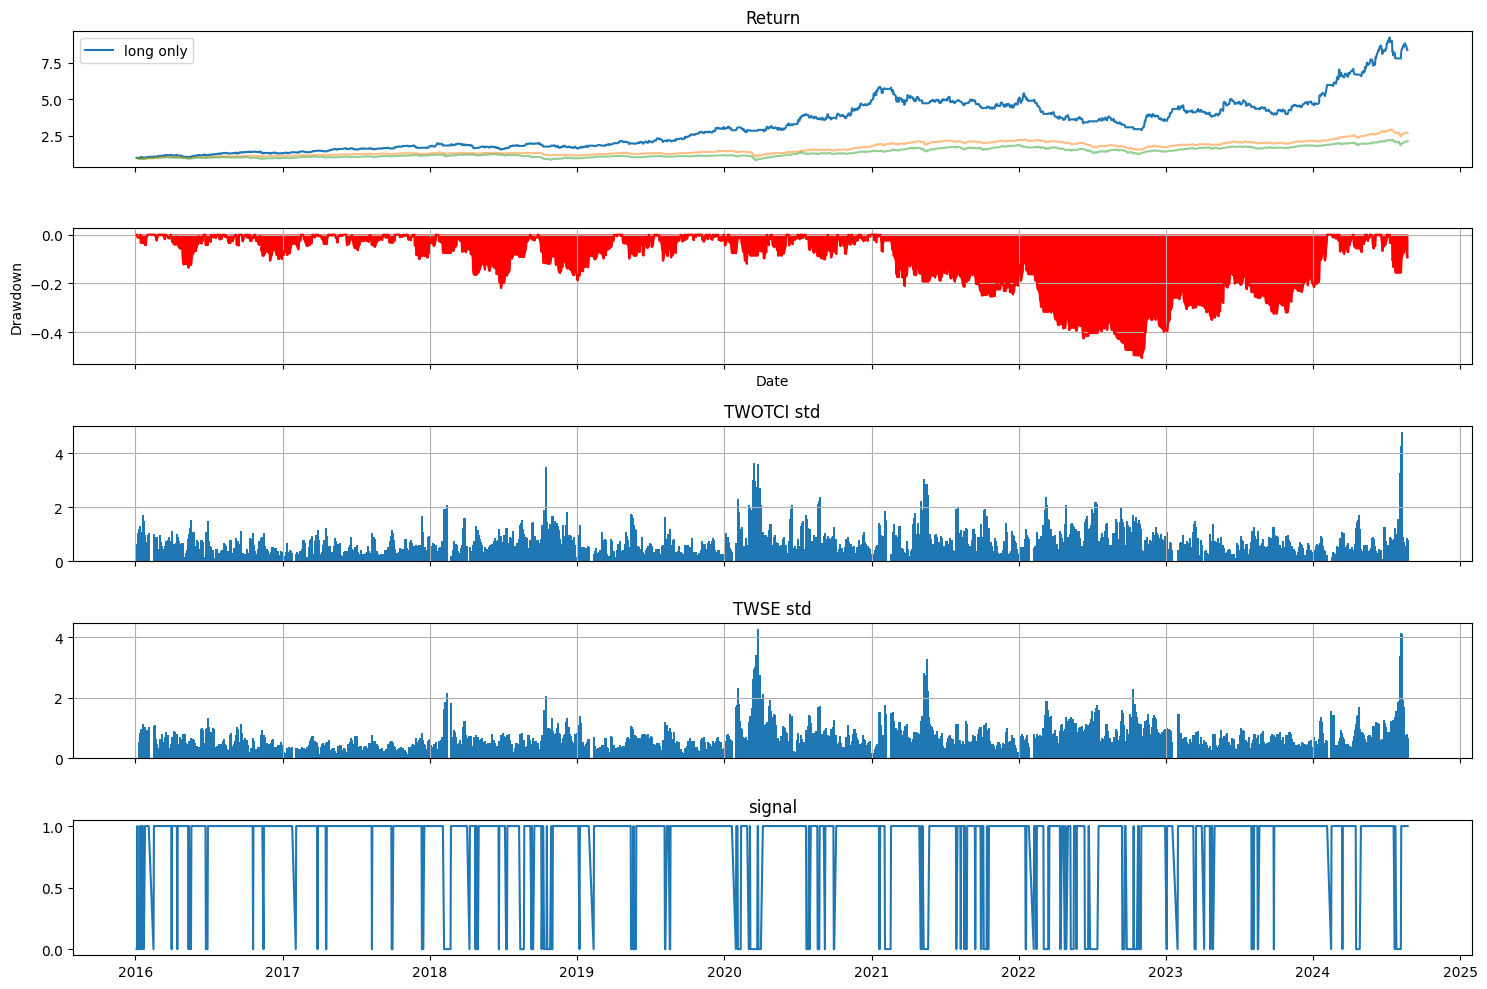

da
2024-08-19    8.644601
2024-08-20    8.614453
2024-08-21    8.363215
2024-08-22    8.363215
2024-08-23         NaN
Name: cumprod_final_signal, dtype: float64

In [59]:
# long short
fig, ax = plt.subplots(5, 1, figsize=(15, 10), sharex=True)

def calculate_return_on_signal(row, signal_col='final_signal', type_='l'):
    # long short
    if type_ == "ls":
        return row['pct_change'] if row[signal_col] else -row['pct_change']
    else:
    # long only
        return row['pct_change'] if row[signal_col] else 0

import yfinance as yf
tsm = yf.download("TSM", start=final_df['da'].iloc[0], progress=False)

final_df['close'] = tsm['Close']
final_df['pct_change'] = final_df['close'].pct_change().shift(-1)
final_df_da = final_df[final_df['da'] >='2016-01-01']
final_df_da['daily_ret_final_signal'] = final_df_da.apply(calculate_return_on_signal, args=("signal_ed","l"), axis=1)
final_df_da['cumprod_final_signal'] = (1+final_df_da['daily_ret_final_signal']).cumprod()

# final_df_da['daily_ret_final_signal_ls'] = final_df_da.apply(calculate_return_on_signal, args=("signal_ed","ls"), axis=1)
# final_df_da['cumprod_final_signal_ls'] = (1+final_df_da['daily_ret_final_signal_ls']).cumprod()
# ax[0].plot(final_df_da.index, final_df_da['cumprod_final_signal_ls'], label='long short')

ax[0].plot(final_df_da.index, final_df_da['cumprod_final_signal'], label='long only')
ax[0].plot(final_df_da.index, (1+final_df_da['Return']).cumprod(), alpha=0.5)
ax[0].plot(final_df_da.index, (1+final_df_da['TWOTCI_CL'].pct_change()).cumprod(), alpha=0.5)
ax[0].legend()
ax[0].set_title('Return')
def from_nav_to_mdd(nav_all):
    Roll_Max = nav_all.rolling(len(nav_all), min_periods=1).max()
    Daily_Drawdown = nav_all/Roll_Max - 1.0
    return Daily_Drawdown
    
mdd = from_nav_to_mdd(final_df_da['cumprod_final_signal'])
ax[1].plot(final_df_da.index,mdd, label='Maximum Drawdown', color='red')
ax[1].fill_between(final_df_da.index, mdd, color='red')
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('Date')
ax[1].grid()

ax[2].set_title("TWOTCI std")
ax[2].bar(final_df_da.index, final_df_da['TWOTCI_RETURN_STDDEV'],width=5)
ax[2].grid()

ax[3].set_title("TWSE std")
ax[3].bar(final_df_da.index, final_df_da['return_stddev'], width=5)
ax[3].grid()

ax[4].set_title("signal")
ax[4].plot(final_df_da['da'], final_df_da['signal_ed'])

plt.tight_layout()
plt.show()
final_df_da['cumprod_final_signal'].tail()

<Axes: xlabel='Date'>

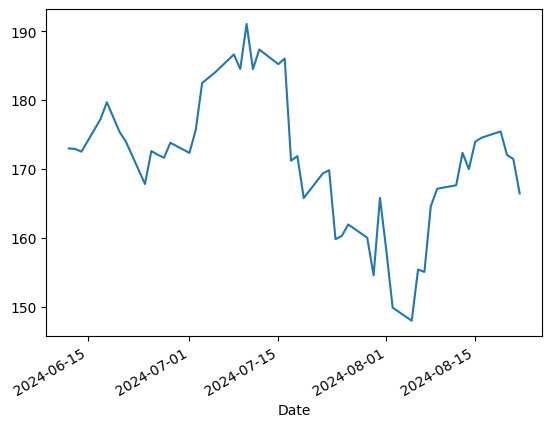

In [64]:
tsm['Close'].tail(50).plot()

In [62]:
final_df_da[['signal_ed', 'signal_comment']].tail(20)

,signal_ed,signal_comment
da,,
2024-07-29,0,4.0
2024-07-30,0,4.0
2024-07-31,0,4.0
2024-08-01,0,4.0
2024-08-02,0,4.0
2024-08-05,0,4.0
2024-08-06,0,4.0
2024-08-07,1,2.0
2024-08-08,1,2.0


In [38]:
# signal
final_df_da['signal_ed'].tail(20), tsm['Close'].pct_change().tail().shift(-1)

(da
 2024-07-29    0
 2024-07-30    0
 2024-07-31    0
 2024-08-01    0
 2024-08-02    0
 2024-08-05    0
 2024-08-06    0
 2024-08-07    0
 2024-08-08    0
 2024-08-09    0
 2024-08-12    1
 2024-08-13    1
 2024-08-14    1
 2024-08-15    1
 2024-08-16    1
 2024-08-19    1
 2024-08-20    1
 2024-08-21    1
 2024-08-22    1
 2024-08-23    1
 Name: signal_ed, dtype: int64,
 Date
 2024-08-16    0.005214
 2024-08-19   -0.019436
 2024-08-20   -0.003488
 2024-08-21   -0.029165
 2024-08-22         NaN
 Name: Close, dtype: float64)